In [1]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
import lightgbm
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from matplotlib import rcParams

In [2]:
FEATURES_CSVS_PATH = "features_csvs/"
CATEGORIA_ACTUAL = "nivel_desemp_lengua"
PONDERADOR_ACTUAL = "ponderador_lengua"
CATEGORIA_NIVEL = "lengua"
CATEGORIA_LABEL = "Lengua"

In [3]:
train = pd.read_csv(FEATURES_CSVS_PATH+"train_%s.csv" % CATEGORIA_NIVEL)
test = pd.read_csv(FEATURES_CSVS_PATH+"test_%s.csv" % CATEGORIA_NIVEL)

# Primaria

In [4]:
train = train[train["nivel"]=="primaria"]
test = test[test["nivel"]=="primaria"]

In [5]:
X_columns = [c for c in train.columns if c not in ['alumne_id', PONDERADOR_ACTUAL, CATEGORIA_ACTUAL, 'nivel']]
Y_columns = CATEGORIA_ACTUAL

In [6]:
y_lb = LabelEncoder()

In [7]:
import unidecode
X_train = train[X_columns]
Y_train = y_lb.fit_transform(train[Y_columns])
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_train.columns = [unidecode.unidecode(x) for x in X_train.columns]

In [8]:
import unidecode
X_test = test[X_columns]
Y_test = y_lb.transform(test[Y_columns])
X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]
X_test.columns = [unidecode.unidecode(x) for x in X_test.columns]

In [9]:
X_valid = X_test[:len(X_test)//10]
Y_valid = Y_test[:len(X_test)//10]

split_i = len(X_test)//10

X_test = X_test[split_i:]
Y_test = Y_test[split_i:]

In [10]:
params = {'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'learning_rate': 0.01,
    'num_classes': 4,
    'feature_fraction':0.9,
    'max_depth':20}

In [11]:
d_train = lightgbm.Dataset(X_train, Y_train)

In [12]:
d_valid = lightgbm.Dataset(X_valid, Y_valid)

In [13]:
bst = lightgbm.train(params, d_train, 5000, verbose_eval=500, valid_sets=[d_valid])

[500]	valid_0's multi_logloss: 1.23806
[1000]	valid_0's multi_logloss: 1.2281
[1500]	valid_0's multi_logloss: 1.22553
[2000]	valid_0's multi_logloss: 1.22349
[2500]	valid_0's multi_logloss: 1.22141
[3000]	valid_0's multi_logloss: 1.21944
[3500]	valid_0's multi_logloss: 1.21792
[4000]	valid_0's multi_logloss: 1.2166
[4500]	valid_0's multi_logloss: 1.21656
[5000]	valid_0's multi_logloss: 1.21554


In [14]:
preds = bst.predict(X_test)

In [15]:
print(classification_report(y_lb.inverse_transform(Y_test), y_lb.inverse_transform([np.argmax(p) for p in preds])))

                       precision    recall  f1-score   support

             avanzado       0.49      0.49      0.49     36535
               basico       0.29      0.13      0.18     27375
por_debajo_del_basico       0.38      0.16      0.23     21552
        satisfactorio       0.38      0.60      0.47     46791

             accuracy                           0.40    132253
            macro avg       0.38      0.35      0.34    132253
         weighted avg       0.39      0.40      0.37    132253



In [16]:
np.unique(Y_test, return_counts=True)

(array([0, 1, 2, 3]), array([36535, 27375, 21552, 46791]))

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
cm = confusion_matrix(y_lb.inverse_transform(Y_test), y_lb.inverse_transform([np.argmax(p) for p in preds]), 
                      labels=["por_debajo_del_basico", "basico", "satisfactorio", "avanzado"])

In [19]:
cm_relative = cm/cm.astype(np.float).sum(axis=0)

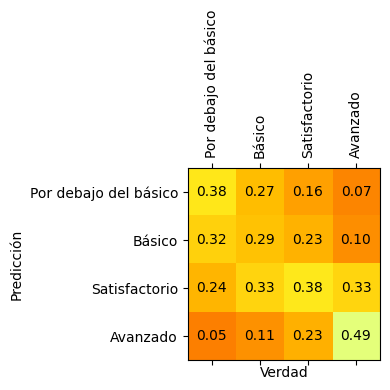

In [20]:
rcParams.update({'figure.autolayout': True})
fig = plt.figure(dpi=100)
axes = fig.add_subplot(1, 1, 1)
color_map = plt.cm.get_cmap('Wistia')
reversed_color_map = color_map.reversed()
axes.matshow(cm_relative, cmap=reversed_color_map)
for (i, j), z in np.ndenumerate(cm_relative):
    axes.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
#axes.set_xticklabels(list(y_lb.classes_))
axes.set_yticklabels(['']+["Por debajo del básico", "Básico", "Satisfactorio", "Avanzado"])
axes.set_xticklabels(['']+["Por debajo del básico", "Básico", "Satisfactorio", "Avanzado"])
plt.ylabel("Predicción")
plt.xlabel("Verdad")
plt.xticks(rotation=90)
plt.savefig("plots/lightgbm_confusion_matrix_%s_primaria.png" % CATEGORIA_NIVEL)

In [21]:
import shap
shap_values = shap.TreeExplainer(bst).shap_values(X_valid)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


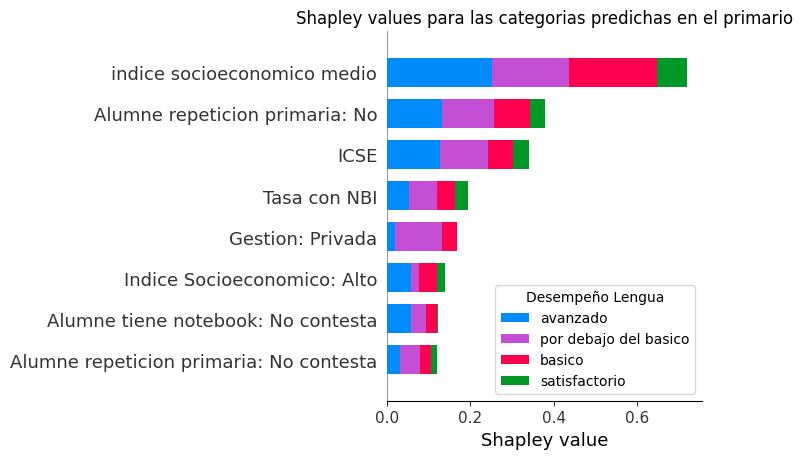

In [22]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.figure(dpi=100)
shap.summary_plot(shap_values, X_test, show=False, max_display=8)
leg = plt.gca().legend()
y_ticks = list(plt.gca().get_yticklabels())
for i in range(len(y_ticks)):
    y_ticks[i].set_text(y_ticks[i].get_text().replace("__", ": ").replace("_", " "))
plt.gca().set_yticklabels(y_ticks)
leg.set_title("Desempeño %s" % CATEGORIA_LABEL)
LABELS = {"Class "+str(k):" ".join(v.split("_")) for k,v in dict(enumerate(y_lb.classes_)).items()}
for t in leg.texts: t.set_text(LABELS[t.get_text()])
plt.title("Shapley values para las categorias predichas en el primario")
plt.xlabel("Shapley value")
plt.savefig("plots/lightgbm_shapley_%s_primaria.png" % CATEGORIA_NIVEL)

# Secundaria

In [23]:
train = pd.read_csv(FEATURES_CSVS_PATH+"train_%s.csv" % CATEGORIA_NIVEL)
test = pd.read_csv(FEATURES_CSVS_PATH+"test_%s.csv" % CATEGORIA_NIVEL)

In [24]:
train = train[train["nivel"]=="secundaria"]
test = test[test["nivel"]=="secundaria"]

In [25]:
X_columns = [c for c in train.columns if c not in ['alumne_id', PONDERADOR_ACTUAL, CATEGORIA_ACTUAL, 'nivel']]
Y_columns = CATEGORIA_ACTUAL

In [26]:
y_lb = LabelEncoder()

In [27]:
import unidecode
X_train = train[X_columns]
Y_train = y_lb.fit_transform(train[Y_columns])
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_train.columns = [unidecode.unidecode(x) for x in X_train.columns]

In [28]:
import unidecode
X_test = test[X_columns]
Y_test = y_lb.transform(test[Y_columns])
X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]
X_test.columns = [unidecode.unidecode(x) for x in X_test.columns]

In [29]:
X_valid = X_test[:len(X_test)//10]
Y_valid = Y_test[:len(X_test)//10]

split_i = len(X_test)//10

X_test = X_test[split_i:]
Y_test = Y_test[split_i:]

In [30]:
params = {'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'learning_rate': 0.01,
    'num_classes': 4,
    'feature_fraction':0.9,
    'max_depth':20}

In [31]:
d_train = lightgbm.Dataset(X_train, Y_train)

In [32]:
d_valid = lightgbm.Dataset(X_valid, Y_valid)

In [33]:
bst = lightgbm.train(params, d_train, 5000, verbose_eval=500, valid_sets=[d_valid])

[500]	valid_0's multi_logloss: 1.19702
[1000]	valid_0's multi_logloss: 1.193
[1500]	valid_0's multi_logloss: 1.19025
[2000]	valid_0's multi_logloss: 1.18863
[2500]	valid_0's multi_logloss: 1.18729
[3000]	valid_0's multi_logloss: 1.18573
[3500]	valid_0's multi_logloss: 1.18439
[4000]	valid_0's multi_logloss: 1.18322
[4500]	valid_0's multi_logloss: 1.18258
[5000]	valid_0's multi_logloss: 1.1815


In [34]:
preds = bst.predict(X_test)

In [35]:
print(classification_report(y_lb.inverse_transform(Y_test), y_lb.inverse_transform([np.argmax(p) for p in preds])))

                       precision    recall  f1-score   support

             avanzado       0.54      0.06      0.11      8702
               basico       0.33      0.02      0.05     17470
por_debajo_del_basico       0.43      0.37      0.40     19568
        satisfactorio       0.47      0.84      0.60     33490

             accuracy                           0.46     79230
            macro avg       0.44      0.33      0.29     79230
         weighted avg       0.44      0.46      0.38     79230



In [36]:
np.unique(Y_test, return_counts=True)

(array([0, 1, 2, 3]), array([ 8702, 17470, 19568, 33490]))

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
cm = confusion_matrix(y_lb.inverse_transform(Y_test), y_lb.inverse_transform([np.argmax(p) for p in preds]), 
                      labels=["por_debajo_del_basico", "basico", "satisfactorio", "avanzado"])

In [39]:
cm_relative = cm/cm.astype(np.float).sum(axis=0)

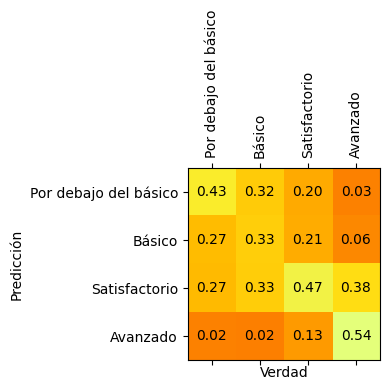

In [40]:
rcParams.update({'figure.autolayout': True})
fig = plt.figure(dpi=100)
axes = fig.add_subplot(1, 1, 1)
color_map = plt.cm.get_cmap('Wistia')
reversed_color_map = color_map.reversed()
axes.matshow(cm_relative, cmap=reversed_color_map)
for (i, j), z in np.ndenumerate(cm_relative):
    axes.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
#axes.set_xticklabels(list(y_lb.classes_))
axes.set_yticklabels(['']+["Por debajo del básico", "Básico", "Satisfactorio", "Avanzado"])
axes.set_xticklabels(['']+["Por debajo del básico", "Básico", "Satisfactorio", "Avanzado"])
plt.ylabel("Predicción")
plt.xlabel("Verdad")
plt.xticks(rotation=90)
plt.savefig("plots/lightgbm_confusion_matrix_%s_secundaria.png" % CATEGORIA_NIVEL)

In [41]:
import shap
shap_values = shap.TreeExplainer(bst).shap_values(X_valid)

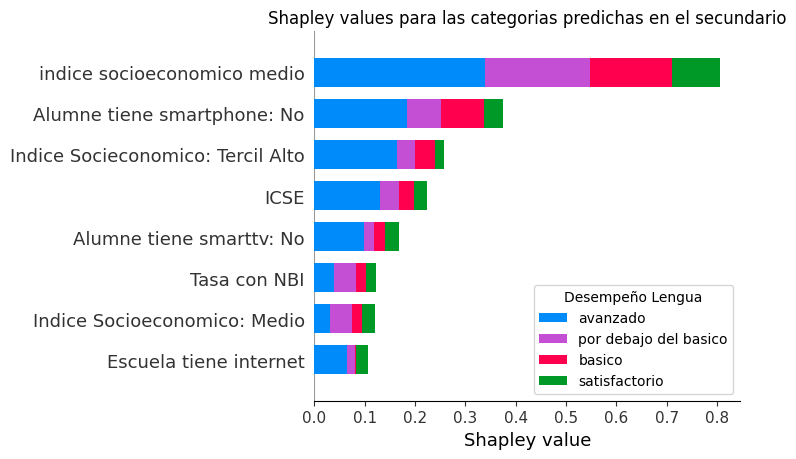

In [42]:
plt.figure(dpi=100)
shap.summary_plot(shap_values, X_valid, show=False, max_display=8)
leg = plt.gca().legend()
y_ticks = list(plt.gca().get_yticklabels())
for i in range(len(y_ticks)):
    y_ticks[i].set_text(y_ticks[i].get_text().replace("__", ": ").replace("_", " "))
plt.gca().set_yticklabels(y_ticks)
leg.set_title("Desempeño %s" % CATEGORIA_LABEL)
LABELS = {"Class "+str(k):" ".join(v.split("_")) for k,v in dict(enumerate(y_lb.classes_)).items()}
for t in leg.texts: t.set_text(LABELS[t.get_text()])
plt.title("Shapley values para las categorias predichas en el secundario")
plt.xlabel("Shapley value")
plt.savefig("plots/lightgbm_shapley_%s_secundaria.png" % CATEGORIA_NIVEL)